In [2]:
# === 1. IMPORTS ===
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, precision_recall_curve,
    confusion_matrix, classification_report, brier_score_loss
)

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === 2. LOAD DATA ===
X = pd.read_csv("data/X_final_selected.csv")
y = pd.read_csv("data/y.csv").squeeze()  # convert to Series

print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")
print("\nDistribution de la cible:")
print(y.value_counts(normalize=True).round(3))


Shape X: (98053, 22)
Shape y: (98053,)

Distribution de la cible:
readmitted
0    0.887
1    0.113
Name: proportion, dtype: float64


In [3]:
# X, y déjà chargés (X: 98k x 22 num; y: binaire)
y.name = "target"  # harmoniser le nom

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(X_train.shape, X_test.shape)
print(y_train.value_counts(normalize=True).round(3))

(78442, 22) (19611, 22)
target
0    0.887
1    0.113
Name: proportion, dtype: float64


In [4]:

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (average_precision_score, roc_auc_score, f1_score,
                             precision_recall_curve, confusion_matrix, classification_report,
                             brier_score_loss)

scaler = StandardScaler()

logreg_L1 = Pipeline([
    ("scaler", scaler),
    ("clf", LogisticRegression(penalty="l1", solver="liblinear",
                               class_weight="balanced", max_iter=200))
])

logreg_L2 = Pipeline([
    ("scaler", scaler),
    ("clf", LogisticRegression(penalty="l2", solver="liblinear",
                               class_weight="balanced", max_iter=200))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"pr_auc": "average_precision", "roc_auc": "roc_auc"}

def cv_scores(pipe, name):
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"{name:>16} | PR-AUC: {scores['test_pr_auc'].mean():.3f} ± {scores['test_pr_auc'].std():.3f} "
          f"| ROC-AUC: {scores['test_roc_auc'].mean():.3f} ± {scores['test_roc_auc'].std():.3f}")
    return scores

scores_L1 = cv_scores(logreg_L1, "LogReg L1")
scores_L2 = cv_scores(logreg_L2, "LogReg L2")
best_pipe = logreg_L1 if scores_L1["test_pr_auc"].mean() >= scores_L2["test_pr_auc"].mean() else logreg_L2
best_name = "LogReg L1" if best_pipe is logreg_L1 else "LogReg L2"
print("\n=> Meilleur sur PR-AUC (CV):", best_name)


       LogReg L1 | PR-AUC: 0.197 ± 0.005 | ROC-AUC: 0.638 ± 0.007
       LogReg L2 | PR-AUC: 0.197 ± 0.005 | ROC-AUC: 0.638 ± 0.007

=> Meilleur sur PR-AUC (CV): LogReg L1


In [6]:
# --- Entraînement final du meilleur modèle ---
best_pipe.fit(X_train, y_train)

# Probabilités sur test
proba_test = best_pipe.predict_proba(X_test)[:, 1]

# Évaluation des performances (indépendantes du seuil)
pr_auc = average_precision_score(y_test, proba_test)
roc_auc = roc_auc_score(y_test, proba_test)
print(f"\nTest PR-AUC  : {pr_auc:.3f}")
print(f"Test ROC-AUC : {roc_auc:.3f}")



Test PR-AUC  : 0.193
Test ROC-AUC : 0.633


In [7]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Trouver le seuil qui maximise le F1-score
p, r, t = precision_recall_curve(y_test, proba_test)
f1 = 2 * p * r / (p + r + 1e-12)
best_idx = np.nanargmax(f1)
thr = t[best_idx-1] if 0 < best_idx < len(t) else 0.5

y_pred = (proba_test >= thr).astype(int)
print(f"Seuil optimal (max F1): {thr:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


Seuil optimal (max F1): 0.489

Classification report:
              precision    recall  f1-score   support

           0      0.917     0.663     0.770     17398
           1      0.166     0.529     0.253      2213

    accuracy                          0.648     19611
   macro avg      0.542     0.596     0.511     19611
weighted avg      0.832     0.648     0.711     19611

Confusion matrix:
 [[11539  5859]
 [ 1043  1170]]


Brier score (plus petit = mieux) : 0.2325


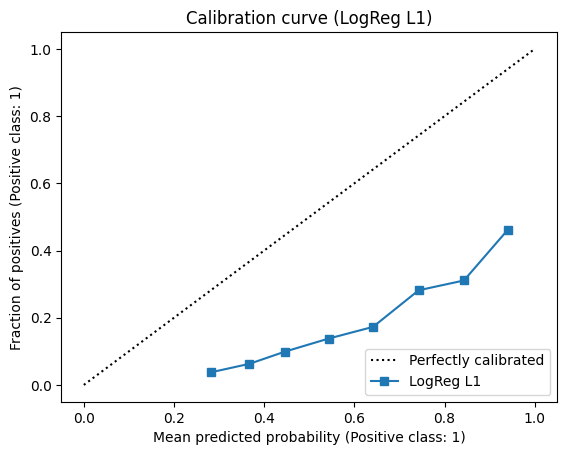

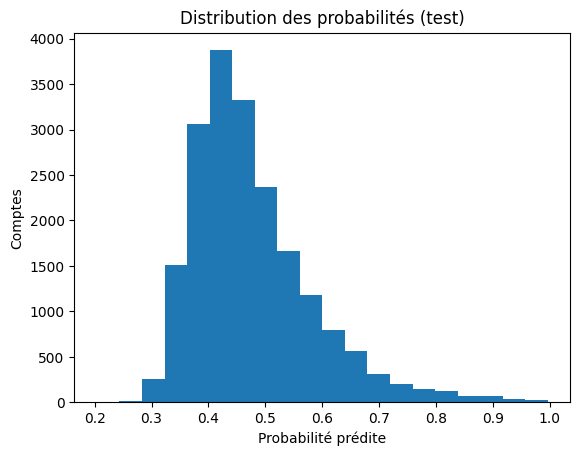

In [8]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

brier = brier_score_loss(y_test, proba_test)
print(f"Brier score (plus petit = mieux) : {brier:.4f}")

disp = CalibrationDisplay.from_predictions(y_test, proba_test, n_bins=10, name=best_name)
plt.title(f"Calibration curve ({best_name})")
plt.show()

plt.hist(proba_test, bins=20)
plt.xlabel("Probabilité prédite")
plt.ylabel("Comptes")
plt.title("Distribution des probabilités (test)")
plt.show()


In [9]:
import pandas as pd
import numpy as np

clf = best_pipe.named_steps["clf"]
coef = pd.Series(clf.coef_.ravel(), index=X_train.columns, name="beta")
odds = np.exp(coef).rename("odds_ratio")

interpret_table = pd.concat([coef, odds], axis=1)
interpret_table["abs_beta"] = interpret_table["beta"].abs()
interpret_table = interpret_table.sort_values("abs_beta", ascending=False)

print("Top 15 variables par importance :")
display(interpret_table.head(15)[["beta", "odds_ratio"]])


Top 15 variables par importance :


,beta,odds_ratio
number_inpatient,0.359805,1.433050
discharge_disposition_id,0.138260,1.148275
number_diagnoses,0.099873,1.105031
time_in_hospital,0.081108,1.084489
num_procedures,-0.076196,0.926635
number_emergency,0.074847,1.077719
diag_1,-0.068030,0.934233
num_medications,0.052531,1.053936
metformin,-0.041791,0.959071
diag_2,-0.028794,0.971617


In [10]:
import pandas as pd
import numpy as np

# Extraire le modèle interne
clf = best_pipe.named_steps["clf"]

coef = pd.Series(clf.coef_.ravel(), index=X_train.columns, name="beta")
odds = np.exp(coef).rename("odds_ratio")

interpret = pd.concat([coef, odds], axis=1)
interpret["abs_beta"] = interpret["beta"].abs()
interpret = interpret.sort_values("abs_beta", ascending=False)

print("Top 20 variables les plus influentes (|β|) :")
display(interpret.head(20)[["beta","odds_ratio"]])

def explain_row(row):
    sign = "augmente" if row["beta"]>0 else "diminue"
    return f"{row.name} : β={row['beta']:.3f}, OR={row['odds_ratio']:.2f} → {sign} la probabilité de réadmission"

print("\nInterprétation qualitative (Top 10) :")
for i,(name,row) in enumerate(interpret.head(10).iterrows(),1):
    print(f"{i}.", explain_row(row))


Top 20 variables les plus influentes (|β|) :


,beta,odds_ratio
number_inpatient,0.359805,1.433050
discharge_disposition_id,0.138260,1.148275
number_diagnoses,0.099873,1.105031
time_in_hospital,0.081108,1.084489
num_procedures,-0.076196,0.926635
number_emergency,0.074847,1.077719
diag_1,-0.068030,0.934233
num_medications,0.052531,1.053936
metformin,-0.041791,0.959071
diag_2,-0.028794,0.971617



Interprétation qualitative (Top 10) :
1. number_inpatient : β=0.360, OR=1.43 → augmente la probabilité de réadmission
2. discharge_disposition_id : β=0.138, OR=1.15 → augmente la probabilité de réadmission
3. number_diagnoses : β=0.100, OR=1.11 → augmente la probabilité de réadmission
4. time_in_hospital : β=0.081, OR=1.08 → augmente la probabilité de réadmission
5. num_procedures : β=-0.076, OR=0.93 → diminue la probabilité de réadmission
6. number_emergency : β=0.075, OR=1.08 → augmente la probabilité de réadmission
7. diag_1 : β=-0.068, OR=0.93 → diminue la probabilité de réadmission
8. num_medications : β=0.053, OR=1.05 → augmente la probabilité de réadmission
9. metformin : β=-0.042, OR=0.96 → diminue la probabilité de réadmission
10. diag_2 : β=-0.029, OR=0.97 → diminue la probabilité de réadmission
